In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import nltk
import re
from unidecode import unidecode
#from wordcloud import WordCloud
import os
import emoji
from collections import Counter
from sentistrength import PySentiStr

sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8) # não sei o motivo, mas o use acima reseta o size.

In [30]:
def drop_indef(dataframe, coluna):
    return dataframe[dataframe[coluna] != 'indef']

def convert_to_datetime(dataframe, coluna_data):
    return pd.to_datetime(dataframe[coluna_data])

def filter_reviews_by_year(dataframe, ano, coluna_data='data_avaliacao'):
    df_without_indef = drop_indef(dataframe, coluna_data)
    df_without_indef[coluna_data] = convert_to_datetime(df_without_indef, coluna_data)
    expressao = coluna_data+'.dt.year >= ' + str(ano)
    return df_without_indef.query(expressao)

def normalize(df):
    return (df-df.mean())/df.std()

def removerAcentosECaracteresEspeciais(frase):
    
    frase_sem_acento = unidecode.unidecode(frase) #remove acentos
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', frase_sem_acento)

def removerAcentosECaracteresEspeciais(frase):
    
    frase_sem_acento = unidecode(frase) #remove acentos
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', frase_sem_acento)

def tokenize_frase(frase):
    token_pontuacao = nltk.tokenize.WordPunctTokenizer()
    stopwords = nltk.corpus.stopwords.words('portuguese')
    #frase_sem_acento = removerAcentosECaracteresEspeciais(frase).lower()
    frase_splitted = token_pontuacao.tokenize(frase.lower())
    nova_frase = ' '.join(filter(lambda palavra: palavra not in stopwords, frase_splitted))

    return ' '.join(removerAcentosECaracteresEspeciais(nova_frase).split())

def wordcloud(dataframe, titulo, cidade, coluna_texto=''):
    titulo = titulo + ' em ' + cidade
    if coluna_texto == '':
        todas_palavras = ' '.join(dataframe)
    else:
        todas_palavras = ' '.join([texto for texto in dataframe[coluna_texto]]) #lista contendo todas as frases

    word_cloud = WordCloud(width=1200, 
                            height=800, 
                            max_font_size=110, 
                            background_color='gray',
                            max_words=50,
                            colormap='gist_rainbow').generate(todas_palavras)
    plt.imshow(word_cloud)
    plt.title(titulo)

    plt.axis("off")
    title = 'wordcloud_'+titulo.replace(' ','_').lower()
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))
    plt.show()

def carrega_cidades(cidade):
    hotel = pd.read_csv(os.path.join(cidade, 'hoteis.csv')).drop_duplicates('hotel_id')
    restaurantes = pd.read_csv(os.path.join(cidade, 'restaurantes.csv')).drop_duplicates()
    atracoes = pd.read_csv(os.path.join(cidade, 'atracoes.csv')).drop_duplicates()

    aval_hotel = pd.read_csv(os.path.join(cidade, 'avaliacoes-hoteis.csv')).drop_duplicates()
    aval_rest = pd.read_csv(os.path.join(cidade, 'avaliacoes-restaurantes.csv'))
    aval_rest = aval_rest.drop_duplicates(aval_rest.columns[:-2])
    aval_atracoes = pd.read_csv(os.path.join(cidade, 'avaliacoes-atracoes.csv')).drop_duplicates()


    data = {'estabelecimentos': {'hoteis': hotel, 'restaurantes': restaurantes, 'atracoes': atracoes},
            'avaliacoes': {'aval_hotel': aval_hotel, 'aval_rest': aval_rest, 'aval_atracoes': aval_atracoes}}
    return data

def inicializa_diretorios_graficos(cidade):
    if not os.path.exists('graficos'):
        os.mkdir('graficos')

    if not os.path.exists(os.path.join('graficos', cidade)):
        os.mkdir(os.path.join('graficos', cidade))

def descreve_cidades(cidade):
    inicializa_diretorios_graficos(cidade)
    dados_cidade = carrega_cidades(cidade)
    estabelecimentos = dados_cidade['estabelecimentos']
    avaliacoes = dados_cidade['avaliacoes']
    avaliacoes_recentes = filtra_avaliacoes_antigas(avaliacoes)
    avaliacoes_pandemia = filtra_avaliacoes_antigas(avaliacoes, ano=2019)

    # distribuicao_hoteis(estabelecimentos['hoteis'], cidade)
    # distribuicao_preco_restaurantes(estabelecimentos['restaurantes'], cidade)

    # reviews_por_mes(cidade, avaliacoes_recentes)
    # reviews_por_ano(cidade, avaliacoes_recentes)

    # compara_aval_hotel_por_tipo(cidade, estabelecimentos['hoteis'], avaliacoes_recentes['aval_hotel'])
    # compara_aval_rest_por_tipo(cidade, estabelecimentos['restaurantes'], avaliacoes_recentes['aval_rest'])

    # aval_durante_pandemia(cidade, avaliacoes_pandemia)

    # tam_aval(cidade, avaliacoes_pandemia, 'characters')
    # tam_aval(cidade, avaliacoes_pandemia, 'words')

    # porcentagem_comentarios_com_emoji(cidade, avaliacoes_pandemia)
    distribuicao_emojis(cidade, avaliacoes_pandemia, 2020)

def wordclouds(cidade):
    dados_cidade = carrega_cidades(cidade)
    avaliacoes = dados_cidade['avaliacoes']
    avaliacoes_pandemia = filtra_avaliacoes_antigas(avaliacoes, ano=2019)
    avaliacoes_processadas = pre_processa_aval(avaliacoes_pandemia)
    word_clouds_por_cidade(cidade, avaliacoes_processadas)


def distribuicao_hoteis(hoteis, cidade):
    tipos_hoteis = hoteis.groupby('tipo')['nome'].count().rename({'Chale': 'Cottage', 'Hostel': 'Hostel', 'Hotel':'Hotel', 'Pousada': 'Lodge', 'indef':'indef'})
    tipos_hoteis.plot.bar()
    plt.xlabel('Hotel Type')
    plt.ylabel('Number of entires')
    plt.title('Distribution of hotel types in ' + cidade)
    plt.tight_layout()
    title = (cidade.lower()+' hotel distribution').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def distribuicao_preco_restaurantes(restaurantes, cidade):
    restaurantes.groupby('categoria_preco')['nome'].count().rename({'$$$$': '\\$\\$\\$\\$'}).plot.bar()
    plt.xlabel('Price category')
    plt.ylabel('Number of entires')
    plt.title('Distribution of restaurants price categories in ' + cidade)
    plt.tight_layout()
    title = (cidade.lower()+' restaurant price category distribution').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def filtra_avaliacoes_antigas(avaliacoes, ano=2015):
    aval_hotel_recente = filter_reviews_by_year(avaliacoes['aval_hotel'], ano)
    aval_rest_recente = filter_reviews_by_year(avaliacoes['aval_rest'], ano)
    aval_atracoes_recente = filter_reviews_by_year(avaliacoes['aval_atracoes'], ano)

    data = {'aval_hotel': aval_hotel_recente, 'aval_rest': aval_rest_recente, 'aval_atracoes': aval_atracoes_recente}
    return data

def reviews_por_mes(cidade, avaliacoes):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16, 24))

    avaliacoes['aval_hotel'].set_index('data_avaliacao')['estabelecimento'].resample('M').count().plot(ax=ax1)
    ax1.set(xlabel='Date', ylabel='Number of reviews')
    ax1.set_title("Hotel reviews by month in " + cidade)
    avaliacoes['aval_rest'].set_index('data_avaliacao')['estabelecimento'].resample('M').count().plot(ax=ax2)
    ax2.set(xlabel='Date', ylabel='Number of reviews')
    ax2.set_title("Restaurant reviews by month in " + cidade)
    avaliacoes['aval_atracoes'].set_index('data_avaliacao')['estabelecimento'].resample('M').count().plot(ax=ax3)
    ax3.set(xlabel='Date', ylabel='Number of reviews')
    ax3.set_title("Attraction reviews by month in " + cidade)

    plt.tight_layout()
    title = (cidade.lower()+' reviews by month').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def reviews_por_ano(cidade, avaliacoes):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16, 24))

    avaliacoes['aval_hotel'].groupby(avaliacoes['aval_hotel']['data_avaliacao'].dt.year)['estabelecimento'].count().plot(ax=ax1, kind='bar')
    ax1.set(xlabel='Year', ylabel='Number of reviews')
    ax1.set_title("Hotel reviews by year in " + cidade)
    avaliacoes['aval_rest'].groupby(avaliacoes['aval_rest']['data_avaliacao'].dt.year)['estabelecimento'].count().plot(ax=ax2, kind='bar')
    ax2.set(xlabel='Year', ylabel='Number of reviews')
    ax2.set_title("Restaurant reviews by year in " + cidade)
    avaliacoes['aval_atracoes'].groupby(avaliacoes['aval_atracoes']['data_avaliacao'].dt.year)['estabelecimento'].count().plot(ax=ax3, kind='bar')
    ax3.set(xlabel='Year', ylabel='Number of reviews')
    ax3.set_title("Attraction reviews by year in " + cidade)

    plt.tight_layout()
    title = (cidade.lower()+' reviews by year').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def compara_aval_hotel_por_tipo(cidade, hoteis, aval_hotel):
    merged_df = pd.merge(hoteis, aval_hotel, how='right', left_on='hotel_id', right_on='estabelecimento_id')

    avaliacoes_tipo_hotel = merged_df[merged_df['tipo'] == 'Hotel']
    avaliacoes_tipo_pousada = merged_df[merged_df['tipo'] == 'Pousada']

    plt.figure(figsize=(18,10))
    plt.plot(normalize(avaliacoes_tipo_hotel.set_index('data_avaliacao')['estabelecimento'].resample('M').count()))
    plt.plot(normalize(avaliacoes_tipo_pousada.set_index('data_avaliacao')['estabelecimento'].resample('M').count()))

    plt.xlabel('Date')
    plt.ylabel('Number of reviews')
    plt.title('Hotel reviews by type (normalized) in ' + cidade)
    plt.legend(['Hotel', 'Lodge'])
    plt.tight_layout()
    title = (cidade.lower()+' reviews by hotel type').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def compara_aval_rest_por_tipo(cidade, restaurantes, aval_rest):
    merged_df = pd.merge(restaurantes, aval_rest, how='right', left_on='restaurante_id', right_on='estabelecimento_id')

    avaliacoes_rest_barato = merged_df[merged_df['categoria_preco'] == '$']
    avaliacoes_rest_med = merged_df[merged_df['categoria_preco'] == '$$ - $$$']

    plt.figure(figsize=(18,10))
    plt.plot(normalize(avaliacoes_rest_barato.set_index('data_avaliacao')['estabelecimento'].resample('M').count()))
    plt.plot(normalize(avaliacoes_rest_med.set_index('data_avaliacao')['estabelecimento'].resample('M').count()))

    plt.xlabel('Date')
    plt.ylabel('Number of reviews')
    plt.title('Restaurant reviews by price category in ' + cidade)
    plt.legend(['$', '$$ - $$$'])
    plt.tight_layout()
    title = (cidade.lower()+' reviews by restaurant category').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def aval_durante_pandemia(cidade, avaliacoes):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16, 24))

    avaliacoes['aval_hotel'].set_index('data_avaliacao')['estabelecimento'].resample('M').count().plot(ax=ax1, style='-', marker='o', markerfacecolor='black', markersize=8)
    ax1.set(xlabel='Date', ylabel='Number of reviews')
    ax1.set_title("Hotel reviews by month in " + cidade)
    avaliacoes['aval_rest'].set_index('data_avaliacao')['estabelecimento'].resample('M').count().plot(ax=ax2, style='-', marker='o', markerfacecolor='black', markersize=8)
    ax2.set(xlabel='Date', ylabel='Number of reviews')
    ax2.set_title("Restaurant reviews by month in " + cidade)
    avaliacoes['aval_atracoes'].set_index('data_avaliacao')['estabelecimento'].resample('M').count().plot(ax=ax3, style='-', marker='o', markerfacecolor='black', markersize=8)
    ax3.set(xlabel='Date', ylabel='Number of reviews')
    ax3.set_title("Attraction reviews by month in " + cidade)

    plt.tight_layout()
    title = (cidade.lower()+' reviews by month pandemic').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def tam_aval(cidade, avaliacoes, mode):
    if mode =='characters':
        size_column = 'tam_chars'
        avaliacoes['aval_hotel'][size_column] = avaliacoes['aval_hotel'].apply(lambda row: len(row['conteudo']), axis=1)
        avaliacoes['aval_rest'][size_column] = avaliacoes['aval_rest'].apply(lambda row: len(row['conteudo']), axis=1)
        avaliacoes['aval_atracoes'][size_column] = avaliacoes['aval_atracoes'].apply(lambda row: len(row['conteudo']), axis=1)
    elif mode == 'words':
        size_column = 'tam_words'
        avaliacoes['aval_hotel'][size_column] = avaliacoes['aval_hotel'].apply(lambda row: len(row['conteudo'].split()), axis=1)
        avaliacoes['aval_rest'][size_column] = avaliacoes['aval_rest'].apply(lambda row: len(row['conteudo'].split()), axis=1)
        avaliacoes['aval_atracoes'][size_column] = avaliacoes['aval_atracoes'].apply(lambda row: len(row['conteudo'].split()), axis=1)
    else:
        print('Modo incorreto (characters/words)!')
        return

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16, 24))

    avaliacoes['aval_hotel'].set_index('data_avaliacao')[size_column].resample('M').mean().fillna(0).plot(ax=ax1, style='-', marker='o', markerfacecolor='black', markersize=8)
    ax1.set(xlabel='Date', ylabel='Average review length')
    ax1.set_title('Hotel review length in ' + cidade + ' by ' + mode)
    avaliacoes['aval_rest'].set_index('data_avaliacao')[size_column].resample('M').mean().fillna(0).plot(ax=ax2, style='-', marker='o', markerfacecolor='black', markersize=8)
    ax2.set(xlabel='Date', ylabel='Average review length')
    ax2.set_title('Restaurant review length in ' + cidade + ' by ' + mode)
    avaliacoes['aval_atracoes'].set_index('data_avaliacao')[size_column].resample('M').mean().fillna(0).plot(ax=ax3, style='-', marker='o', markerfacecolor='black', markersize=8)
    ax3.set(xlabel='Date', ylabel='Average review length')
    ax3.set_title('Attraction review length in ' + cidade + ' by ' + mode)

    plt.tight_layout()
    title = (cidade.lower()+' review length ' + mode).replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def pre_processa_aval(avaliacoes):
    aval_hotel_pt = avaliacoes['aval_hotel'].query('idioma == "pt"')
    aval_rest_pt = avaliacoes['aval_rest'].query('idioma == "pt"')
    aval_atr_pt = avaliacoes['aval_atracoes'].query('idioma == "pt"')

    aval_hotel_pt['processado'] = aval_hotel_pt.apply(lambda row: tokenize_frase(row['conteudo']), axis=1)
    aval_rest_pt['processado'] = aval_rest_pt.apply(lambda row: tokenize_frase(row['conteudo']), axis=1)
    aval_atr_pt['processado'] = aval_atr_pt.apply(lambda row: tokenize_frase(row['conteudo']), axis=1)

    return {'aval_hotel': aval_hotel_pt, 'aval_rest': aval_rest_pt, 'aval_atracoes': aval_atr_pt}

def desenha_wordclouds(avaliacoes, modo, cidade):
    wordcloud(avaliacoes.query('data_avaliacao.dt.year == 2019 and data_avaliacao.dt.month <= 6'), modo.capitalize() + ' - Primeiro semestre 2019', cidade, 'processado')
    wordcloud(avaliacoes.query('data_avaliacao.dt.year == 2019 and data_avaliacao.dt.month > 6'), modo.capitalize() + ' - Segundo semestre 2019', cidade, 'processado')
    wordcloud(avaliacoes.query('data_avaliacao.dt.year == 2020 and data_avaliacao.dt.month <= 6'), modo.capitalize() + ' - Primeiro semestre 2020', cidade, 'processado')
    wordcloud(avaliacoes.query('data_avaliacao.dt.year == 2020 and data_avaliacao.dt.month > 6'), modo.capitalize() + '- Segundo semestre 2020', cidade, 'processado')
    wordcloud(avaliacoes.query('data_avaliacao.dt.year >= 2021'), modo.capitalize() + ' - 2021', cidade, 'processado')

def word_clouds_por_cidade(cidade, avaliacoes):
    todos_comentarios = avaliacoes['aval_hotel'][['processado', 'data_avaliacao']].append([avaliacoes['aval_rest'][['processado', 'data_avaliacao']], avaliacoes['aval_atracoes'][['processado', 'data_avaliacao']]], ignore_index=True)

    desenha_wordclouds(todos_comentarios, 'agregado', cidade)
    desenha_wordclouds(avaliacoes['aval_hotel'], 'hotéis', cidade)
    desenha_wordclouds(avaliacoes['aval_rest'], 'restaurantes', cidade)
    desenha_wordclouds(avaliacoes['aval_atracoes'], 'atrações', cidade)

def is_emoji(char):
    for key in emoji.UNICODE_EMOJI:
        if char in emoji.UNICODE_EMOJI[key]:
            return True
    return False

def has_emoji(string):
    for char in string:
        if is_emoji(char):
            return True
    return False

def porcentagem_comentarios_com_emoji(cidade, avaliacoes):
    avaliacoes['aval_hotel']['tem_emoji'] =  avaliacoes['aval_hotel'].apply(lambda row: has_emoji(row['conteudo']), axis=1)
    avaliacoes['aval_rest']['tem_emoji'] =  avaliacoes['aval_rest'].apply(lambda row: has_emoji(row['conteudo']), axis=1)
    avaliacoes['aval_atracoes']['tem_emoji'] =  avaliacoes['aval_atracoes'].apply(lambda row: has_emoji(row['conteudo']), axis=1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16, 24))
    (avaliacoes['aval_hotel'].groupby('tem_emoji')['conteudo'].count()/len(avaliacoes['aval_hotel'])).plot.bar(ax=ax1, rot=0)
    ax1.set(xlabel='Has emoji?', ylabel='Proportion')
    ax1.set_title('Proportion of hotel reviews that have emojis in ' + cidade)
    (avaliacoes['aval_rest'].groupby('tem_emoji')['conteudo'].count()/len(avaliacoes['aval_rest'])).plot.bar(ax=ax2, rot=0)
    ax2.set(xlabel='Has emoji?', ylabel='Proportion')
    ax2.set_title('Proportion of restaurant reviews that have emojis in ' + cidade)
    (avaliacoes['aval_atracoes'].groupby('tem_emoji')['conteudo'].count()/len(avaliacoes['aval_atracoes'])).plot.bar(ax=ax3, rot=0)
    ax3.set(xlabel='Has emoji?', ylabel='Proportion')
    ax3.set_title('Proportion of attraction reviews that have emojis in ' + cidade)

    for ax in (ax1, ax2, ax3):
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center', size='large')
    plt.tight_layout()
    title = (cidade.lower()+' emoji presence distribution').replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def distribuicao_emojis(cidade, avaliacoes, ano):
    todas_palavras_hoteis = ' '.join([texto for texto in avaliacoes['aval_hotel'].query(f"data_avaliacao.dt.year == {ano}")['conteudo']])
    todas_palavras_rest = ' '.join([texto for texto in avaliacoes['aval_rest'].query(f"data_avaliacao.dt.year == {ano}")['conteudo']])
    todas_palavras_atr = ' '.join([texto for texto in avaliacoes['aval_atracoes'].query(f"data_avaliacao.dt.year == {ano}")['conteudo']])

    todos_comentarios = todas_palavras_hoteis + ' ' + todas_palavras_rest + ' ' + todas_palavras_atr

    emojis = list(filter(is_emoji, todos_comentarios))
    c = Counter(emojis)
    df = pd.DataFrame.from_records(c.most_common(10), columns=['emoji','count'])
    print(df)

    df.plot.bar(legend=False, rot=0)
    plt.xlabel('Emojis')
    plt.ylabel('Occurrences')
    plt.title('Emoji distribution in ' + cidade)
    plt.tight_layout()
    title = (cidade.lower()+' emoji distribution').replace(' ','_')
    #plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def analise_sentimento(cidade, aval_processadas, senti, tipo_aval):

    aval_processadas['sentimento'] = aval_processadas.apply(lambda row: senti.getSentiment(row['processado'])[0], axis=1)

    primeiro_semestre_2019 = separa_avaliacoes_por_semestre(aval_processadas, 2019, 1).groupby('sentimento')['sentimento'].count()
    segundo_semestre_2019 = separa_avaliacoes_por_semestre(aval_processadas, 2019, 2).groupby('sentimento')['sentimento'].count()
    primeiro_semestre_2020 = separa_avaliacoes_por_semestre(aval_processadas, 2020, 1).groupby('sentimento')['sentimento'].count()
    segundo_semestre_2020 = separa_avaliacoes_por_semestre(aval_processadas, 2020, 2).groupby('sentimento')['sentimento'].count()
    primeiro_semestre_2021 = separa_avaliacoes_por_semestre(aval_processadas, 2021, 1).groupby('sentimento')['sentimento'].count()

    for table in [primeiro_semestre_2019, segundo_semestre_2019, primeiro_semestre_2020, segundo_semestre_2020, primeiro_semestre_2021]:
        for i in range(-4,5):
            if i not in table:
                table[i]=0

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1,ncols=5 ,figsize=(40, 8))
    primeiro_semestre_2019_total = primeiro_semestre_2019.sum()
    (primeiro_semestre_2019.sort_index()/primeiro_semestre_2019_total).plot.bar(ax=ax1, rot=0)
    ax1.set(xlabel="Sentiment Score", ylabel="Frequency")
    ax1.set_title(f"Sentiment score distribution of {tipo_aval} reviews\nin {cidade}\nFirst semester of 2019 - Total of {primeiro_semestre_2019_total} reviews")

    segundo_semestre_2019_total = segundo_semestre_2019.sum()
    (segundo_semestre_2019.sort_index()/segundo_semestre_2019_total).plot.bar(ax=ax2, rot=0)
    ax2.set(xlabel="Sentiment Score", ylabel="Frequency")
    ax2.set_title(f"Sentiment score distribution of {tipo_aval} reviews\nin {cidade}\nSecond semester of 2019 - Total of {segundo_semestre_2019_total} reviews")

    primeiro_semestre_2020_total = primeiro_semestre_2020.sum()
    (primeiro_semestre_2020.sort_index()/primeiro_semestre_2020_total).plot.bar(ax=ax3, rot=0)
    ax3.set(xlabel="Sentiment Score", ylabel="Frequency")
    ax3.set_title(f"Sentiment score distribution of {tipo_aval} reviews\nin {cidade}\nFirst semester of 2020 - Total of {primeiro_semestre_2020_total} reviews")

    segundo_semestre_2020_total = segundo_semestre_2020.sum()
    (segundo_semestre_2020.sort_index()/segundo_semestre_2020_total).plot.bar(ax=ax4, rot=0)
    ax4.set(xlabel="Sentiment Score", ylabel="Frequency")
    ax4.set_title(f"Sentiment score distribution of {tipo_aval} reviews\nin {cidade}\nSecond semester of 2020 - Total of {segundo_semestre_2020_total} reviews")

    primeiro_semestre_2021_total = primeiro_semestre_2021.sum()
    (primeiro_semestre_2021.sort_index()/primeiro_semestre_2021_total).plot.bar(ax=ax5, rot=0)
    ax5.set(xlabel="Sentiment Score", ylabel="Frequency")
    ax5.set_title(f"Sentiment score distribution of {tipo_aval} reviews\nin {cidade}\nFirst semester of 2021 - Total of {primeiro_semestre_2021_total} reviews")

    for ax in (ax1, ax2, ax3, ax4, ax5):
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            ax.annotate(f'{height:.1%}', (x + width/2, y + height*1.02), ha='center', size='large')

    fig.tight_layout(pad=5.0)
    title = f"{cidade.lower()} sentiment {tipo_aval}".replace(' ','_')
    plt.savefig(os.path.join('graficos', cidade, title+'.png'))

def analise_sentimento_por_semestre(cidade, avaliacoes):
    senti = PySentiStr()
    senti.setSentiStrengthPath("C:/SentStrength_Data/SentiStrengthCom.jar")
    senti.setSentiStrengthLanguageFolderPath("C:/SentStrength_Data")

    aval_processadas = pre_processa_aval(avaliacoes)
    analise_sentimento(cidade, aval_processadas['aval_hotel'], senti, "hotel")
    analise_sentimento(cidade, aval_processadas['aval_rest'], senti, "restaurant")
    analise_sentimento(cidade, aval_processadas['aval_atracoes'], senti, "attraction")

def separa_avaliacoes_por_semestre(avaliacoes, ano, semestre):
    comparacao = '<= 6' if semestre == 1 else '> 6'
    aval_filtrada = avaliacoes.query(f'data_avaliacao.dt.year == {ano} and data_avaliacao.dt.month {comparacao}')

    return aval_filtrada


In [31]:
cidade = 'Tiradentes'

In [32]:
dados_cidade = carrega_cidades(cidade)
estabelecimentos = dados_cidade['estabelecimentos']
avaliacoes = dados_cidade['avaliacoes']
avaliacoes_recentes = filtra_avaliacoes_antigas(avaliacoes)
avaliacoes_pandemia = filtra_avaliacoes_antigas(avaliacoes, ano=2019)

<ipython-input-30-c7188e55217c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_indef[coluna_data] = convert_to_datetime(df_without_indef, coluna_data)
<ipython-input-30-c7188e55217c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_indef[coluna_data] = convert_to_datetime(df_without_indef, coluna_data)


<ipython-input-30-c7188e55217c>:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aval_hotel_pt['processado'] = aval_hotel_pt.apply(lambda row: tokenize_frase(row['conteudo']), axis=1)
<ipython-input-30-c7188e55217c>:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aval_rest_pt['processado'] = aval_rest_pt.apply(lambda row: tokenize_frase(row['conteudo']), axis=1)
<ipython-input-30-c7188e55217c>:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

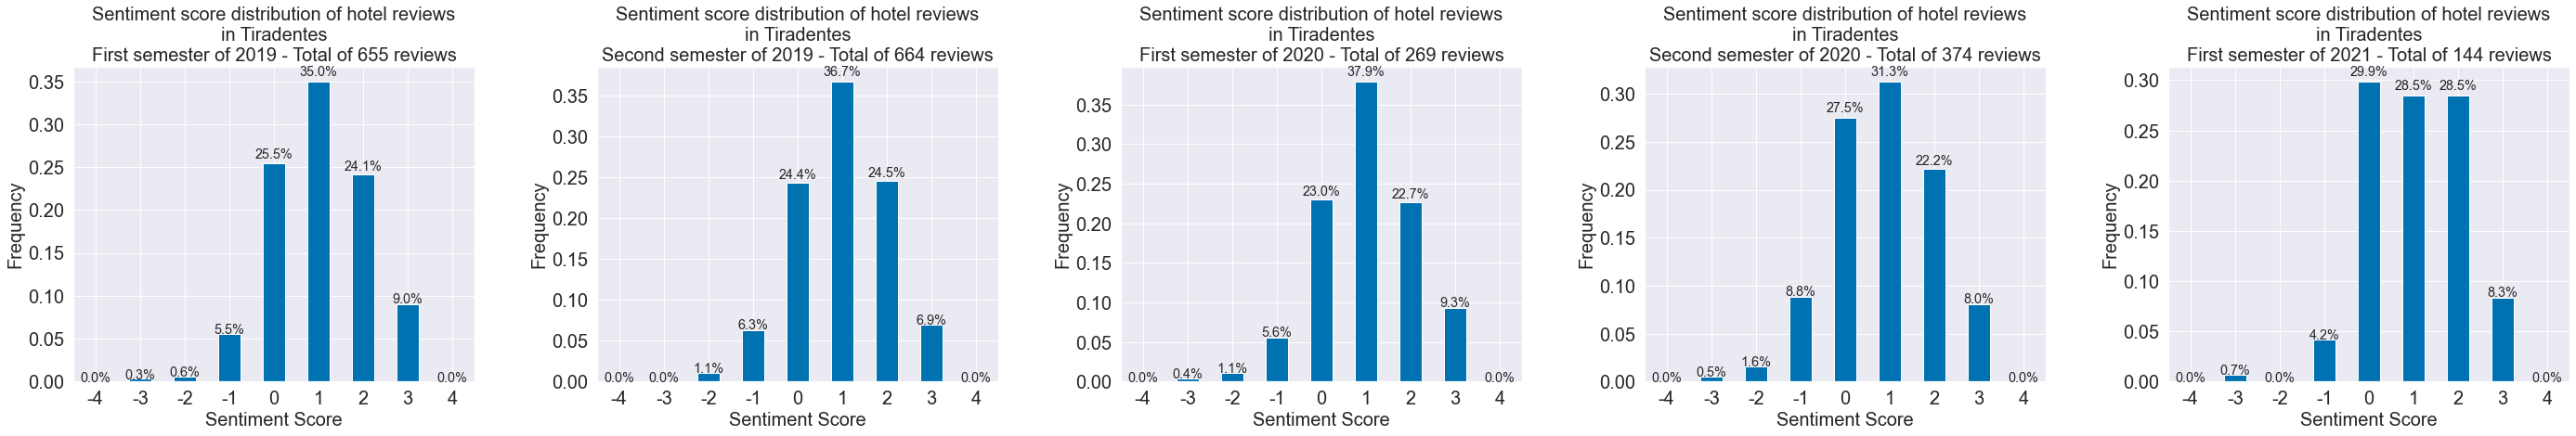

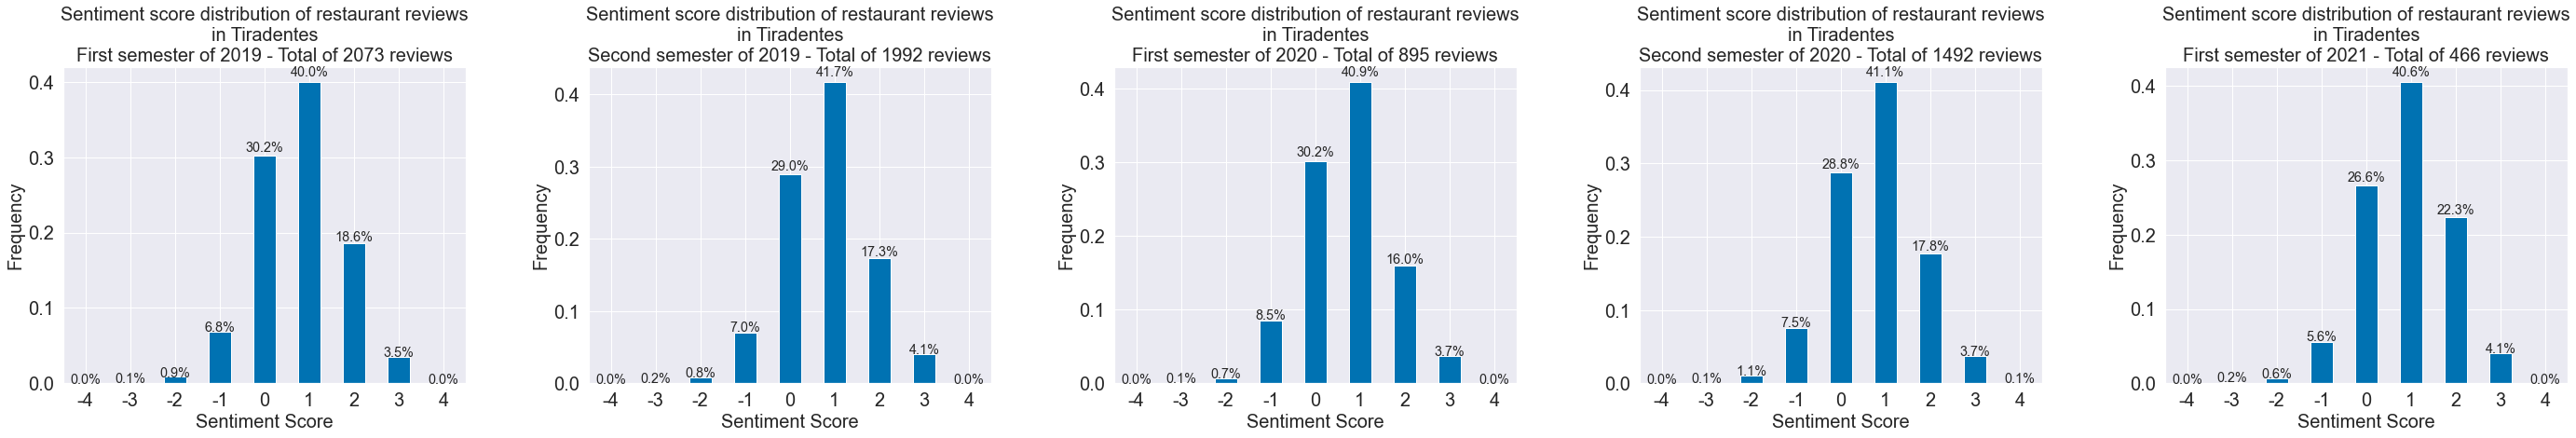

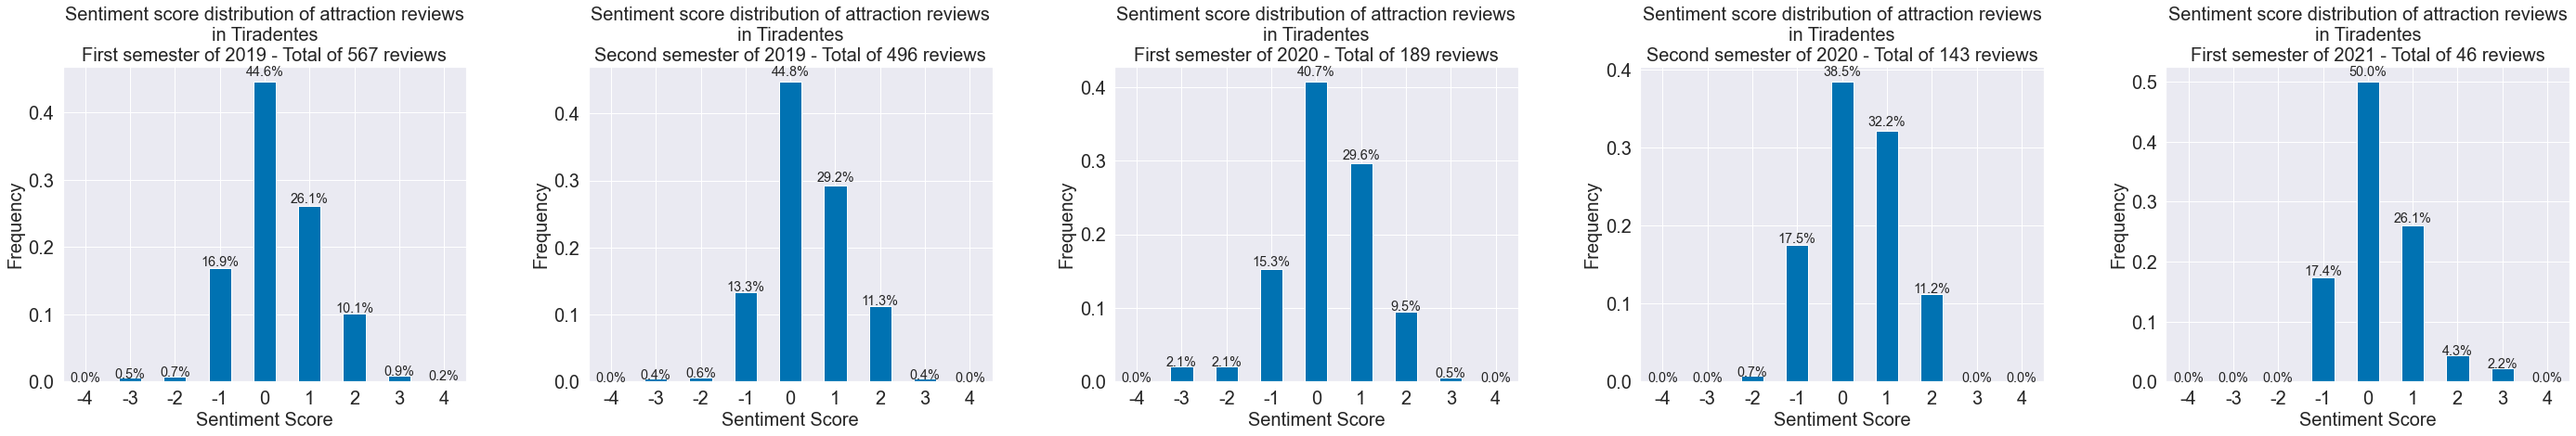

In [33]:
analise_sentimento_por_semestre(cidade, avaliacoes_pandemia)

In [34]:
#descreve_cidades(cidade)

In [35]:
#wordclouds(cidade)